# Sea Ice Tendency / First Derivative

Requirements: The conda/analysis3 module from /g/data/hh5/public/modules. 

**ERA 5 Runs:**

In [1]:
RUNS={
    '025deg_era5':['025deg_era5_iaf'], #(our name: run name(s))
    '025deg_jra55': ['025deg_jra55_iaf_era5comparison'],
    '1deg_era5':['1deg_era5_iaf'],
    '1deg_jra55':['1deg_jra55_iaf_era5comparison']
}


In [2]:
VARS=['aice'] #ice area fraction (daily)
VARS_2D=['area_t','geolat_t','geolon_t']

**OBS Data:**

In [3]:
ST='1979'
ET='2022'
OBS_TIME_SLICE=slice(ST,ET)
_obs_data_dir='/g/data/gv90/P6_data/'
#Using NSIDC, see below for dets

Climatology Time Slice:

n.b. The 1 degree runs only start in 1980, so i've picked a shorter 20 year climatology, rather than a more typical 1981-2010 or 1979-2008

In [4]:
CLIMAT_SLICE=slice('1991,2010')

Check conda/analysis version

In [5]:
! conda env list

# conda environments:
#
                         /g/data/gv90/as2285/miniconda3
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-extremes
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-plots
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker
base                  *  /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04
access-nri-intake-test     /scratch/tm70/as2285/conda/envs/access-nri-intake-test
nmltab                   /scratch/tm70/as2285/conda/envs/nmltab



Work directory:

In [6]:
_scratch_path = !echo /scratch/$PROJECT/$USER/

_work_path=_scratch_path[0]+'era5_datastore/'

In [7]:
cd {_work_path}

/scratch/tm70/as2285/era5_datastore


Load modules:

In [8]:
import intake

import matplotlib.pyplot as plt
from dask.distributed import Client
from datetime import timedelta
import cf_xarray as cfxr
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
import matplotlib.path as mpath
import cmocean.cm as cmo

from datatree import DataTree,map_over_subtree, open_datatree


Load the open_run function

In [9]:
_notebook_path= !echo /g/data/$PROJECT/$USER/

_notebook_path=_notebook_path[0]+'/cosima-recipes'

%run '{_notebook_path}/DocumentedExamples/CICE_Loaders.ipynb'

In [36]:
client = Client()

In [37]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43387,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:44675,Total threads: 6
Dashboard: /proxy/42699/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:46609,


Open the catalog

In [10]:
catalog=intake.open_df_catalog(
    'metacatalog.csv', 
    columns_with_iterables=['model','realm','frequency', 'variable']
)

# The daily data

In [11]:
%%time

si_daily_dt = DataTree.from_dict(dict([
    (iRun, open_by_run(iRun, VARS)) for iRun in RUNS.keys()
]))

CPU times: user 4min 22s, sys: 2min 50s, total: 7min 13s
Wall time: 9min 46s


In [12]:
si_daily_dt['025deg_era5'].ds

<xarray.DatasetView>
Dimensions:   (time: 15918, yt_ocean: 1080, xt_ocean: 1440)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-07-31
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolat_t  (yt_ocean, xt_ocean) float32 ...
    geolon_t  (yt_ocean, xt_ocean) float32 ...
    area_t    (yt_ocean, xt_ocean) float32 ...
Data variables:
    aice      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(21, 1080, 1440), meta=np.ndarray>
Attributes: (12/18)
    title:                                    sea ice model output for CICE
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   Los Alamos Sea Ice Model (CICE)...
    time_period_freq:                         day_1
    comment3:                                 seconds elapsed into model date...
    conventions:                              CF-1.0
    ...                                       ...
    intake_esm_attrs:variable_long_name:      boundaries for time-averaging i...
    intake_esm_attrs:variable_standard_name:  
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
    intake_esm_attrs:file_id:                 iceh_XXXX_XX_daily
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   iceh_XXXX_XX_daily.1day

And the obs data

In [13]:
file_ls=!ls -d /g/data/gv90/P6_data/NSIDC/G02202_V4/south/aggregate/*daily*

In [14]:
sh_cdr_xr = xr.open_mfdataset(
    file_ls, concat_dim='tdim',combine='nested'
).swap_dims(
    {'tdim':'time', 'x':'xgrid','y':'ygrid'}
).rename(
    {'xgrid':'x','ygrid':'y'}
)

In [15]:
sh_cdr_xr

<xarray.Dataset>
Dimensions:                      (time: 16320, y: 332, x: 316)
Coordinates:
  * time                         (time) datetime64[ns] 1978-10-25 ... 2023-06-30
  * x                            (x) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
  * y                            (y) float32 4.338e+06 4.312e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc              (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    projection                   (time) |S1 b'' b'' b'' b'' ... b'' b'' b'' b''
    qa_of_cdr_seaice_conc        (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    latitude                     (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    longitude                    (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-21T21:22:35Z
    time_coverage_start:       1978-10-25T00:00:00Z
    time_coverage_end:         1978-12-31T23:59:59Z

In [16]:
file_ls=!ls -d /g/data/gv90/P6_data/NSIDC/G02202_V4/north/aggregate/*daily*

In [17]:
nh_cdr_xr = xr.open_mfdataset(
    file_ls, concat_dim='tdim',combine='nested'
).swap_dims(
    {'tdim':'time', 'x':'xgrid','y':'ygrid'}
).rename(
    {'xgrid':'x','ygrid':'y'}
)

In [18]:
nh_cdr_xr

<xarray.Dataset>
Dimensions:                         (time: 16320, y: 448, x: 304)
Coordinates:
  * time                            (time) datetime64[ns] 1978-10-25 ... 2023...
  * x                               (x) float32 -3.838e+06 ... 3.738e+06
  * y                               (y) float32 5.838e+06 ... -5.338e+06
Data variables:
    cdr_seaice_conc                 (time, y, x) float32 dask.array<chunksize=(68, 448, 304), meta=np.ndarray>
    melt_onset_day_cdr_seaice_conc  (time, y, x) float32 dask.array<chunksize=(68, 448, 304), meta=np.ndarray>
    nsidc_bt_seaice_conc            (time, y, x) float32 dask.array<chunksize=(68, 448, 304), meta=np.ndarray>
    nsidc_nt_seaice_conc            (time, y, x) float32 dask.array<chunksize=(68, 448, 304), meta=np.ndarray>
    projection                      (time) |S1 b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc           (time, y, x) float32 dask.array<chunksize=(68, 448, 304), meta=np.ndarray>
    spatial_interpolation_flag      (time, y, x) float32 dask.array<chunksize=(68, 448, 304), meta=np.ndarray>
    stdev_of_cdr_seaice_conc        (time, y, x) float32 dask.array<chunksize=(68, 448, 304), meta=np.ndarray>
    temporal_interpolation_flag     (time, y, x) float32 dask.array<chunksize=(68, 448, 304), meta=np.ndarray>
    latitude                        (time, y, x) float32 dask.array<chunksize=(68, 448, 304), meta=np.ndarray>
    longitude                       (time, y, x) float32 dask.array<chunksize=(68, 448, 304), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-21T17:09:43Z
    time_coverage_start:       1978-10-25T00:00:00Z
    time_coverage_end:         1978-12-31T23:59:59Z

The area file

In [19]:
datFile=open(f'{_obs_data_dir}/NSIDC/pss25area_v3.dat', 'rb')
#pss25area_v3.dat: 316 columns x 332 rows
areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape([332,316])

#Divide by 1000 to get km2
areasKmNd_sh=areasDmNd/1000

In [20]:
sh_cdr_xr['area']=xr.DataArray(areasKmNd_sh, dims=['y','x'])

In [21]:
sh_cdr_xr=sh_cdr_xr.set_coords('area')

In [22]:
datFile=open(f'{_obs_data_dir}/NSIDC/psn25area_v3.dat', 'rb')

#pss25area_v3.dat: 448 columns x 304 rows
areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape([448,304])

#Divide by 1000 to get km2
areasKmNd_nh=areasDmNd/1000

In [23]:
nh_cdr_xr['area']=xr.DataArray(areasKmNd_nh, dims=['y','x'])

In [24]:
nh_cdr_xr=nh_cdr_xr.set_coords('area')

In [25]:
cdr_daily_dt = DataTree.from_dict({
    'cdr_sh':sh_cdr_xr.cdr_seaice_conc,
    'cdr_nh':nh_cdr_xr.cdr_seaice_conc
})

# Tendency

We are going to calculate our tendency in the simplest way possible, change from one day to the next

In [26]:
@map_over_subtree
def sh(ds):
    return ds.where(ds.geolat_t<0)

@map_over_subtree
def nh(ds):
    return ds.where(ds.geolat_t>0)

In [27]:
@map_over_subtree
def diff(ds):
    result=ds.diff(dim='time')
    result=result.where(ds<=1)
    result=result.resample({'time':'M'}).sum('time', skipna=True, min_count=5)
    return result.cf.chunk({'time':'auto','Y':-1,'X':-1})

In [28]:
si_rate_sh_dt=open_datatree('./era5_si_rate_sh/', engine='zarr')

In [29]:
si_rate_nh_dt=open_datatree('./era5_si_rate_nh/', engine='zarr')

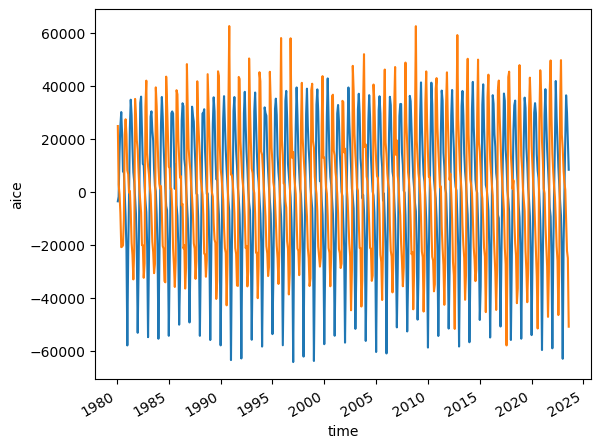

In [30]:
si_rate_sh_dt['025deg_era5'].ds.aice.cf.sum(['X','Y']).plot()

si_rate_nh_dt['025deg_era5'].ds.aice.cf.sum(['X','Y']).plot()

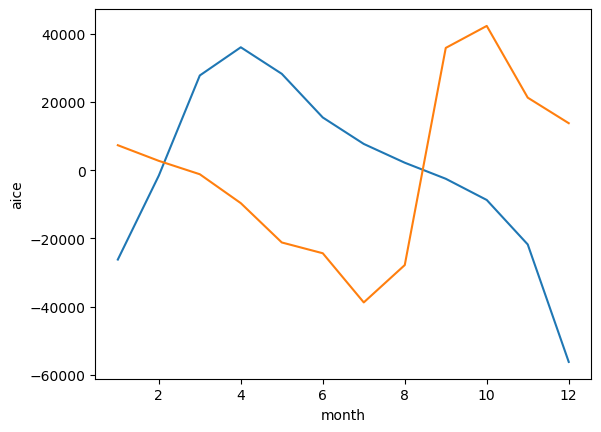

In [31]:
si_rate_sh_dt['025deg_era5'].ds.aice.cf.sum(['X','Y']).groupby('time.month').mean('time').plot()
si_rate_nh_dt['025deg_era5'].ds.aice.cf.sum(['X','Y']).groupby('time.month').mean('time').plot()

In [32]:
cdr_rate_dt=diff(cdr_daily_dt)

In [33]:
cdr_rate_dt

DataTree('None', parent=None)
├── DataTree('cdr_sh')
│       Dimensions:          (time: 537, y: 332, x: 316)
│       Coordinates:
│         * x                (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
│         * y                (y) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
│           area             (y, x) float64 dask.array<chunksize=(332, 316), meta=np.ndarray>
│         * time             (time) datetime64[ns] 1978-10-31 1978-11-30 ... 2023-06-30
│       Data variables:
│           cdr_seaice_conc  (time, y, x) float32 dask.array<chunksize=(312, 332, 316), meta=np.ndarray>
└── DataTree('cdr_nh')
        Dimensions:          (time: 537, y: 448, x: 304)
        Coordinates:
          * x                (x) float32 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
          * y                (y) float32 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
            area             (y, x) float64 dask.array<chunksize=(448, 304), meta=np.ndarray>
          * time             (time) datetime64[ns] 1978-10-31 1978-11-30 ... 2023-06-30
        Data variables:
            cdr_seaice_conc  (time, y, x) float32 dask.array<chunksize=(240, 448, 304), meta=np.ndarray>

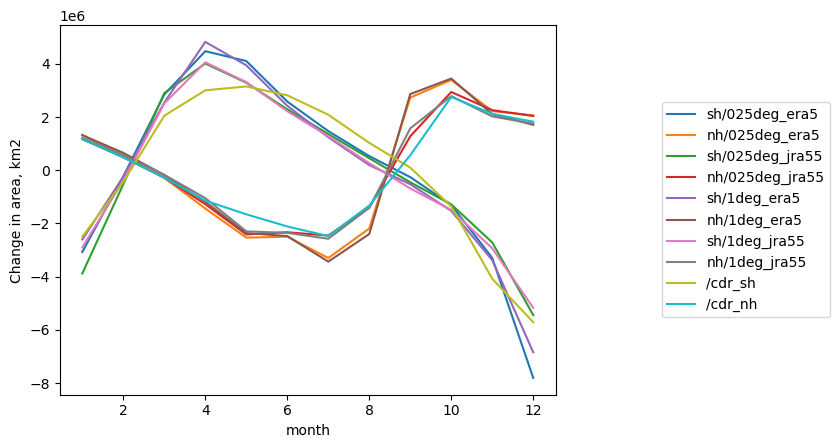

In [45]:
def plot_climat(ds, label):
    ds.cf.sum(['X','Y']).groupby('time.month').mean('time').plot(label=label)

for iGroup in si_rate_sh_dt.groups[1:]:
    ds=si_rate_sh_dt[iGroup].ds.aice*si_rate_sh_dt[iGroup].ds.area_t/1e6
    plot_climat(ds,'sh'+iGroup)

    ds=si_rate_nh_dt[iGroup].ds.aice*si_rate_nh_dt[iGroup].ds.area_t/1e6
    plot_climat(ds,'nh'+iGroup)

for iGroup in cdr_rate_dt.groups[1:]:
    ds=cdr_rate_dt[iGroup].ds
    plot_climat(ds.cdr_seaice_conc*ds.area, iGroup)

plt.ylabel('Change in area, km2')
plt.legend(loc='center left', bbox_to_anchor=(1.2,0.5))

The biggest differences in the SH here, appear to be April, and November/December.

In April, ERA5 sea ice area increases faster than JRA. This is consistent with April mean SAT, which are higher in ERA5 over seaice than in JRA (see ice_analysis_slides.pdf)
In December, ERA5 decreases faster than JRA. Similarly, November JRA SAT are higher in November than ERA, although not in the ABS.

In [69]:
cdr_rate_dt.groups

('/', '/cdr_sh', '/cdr_nh')

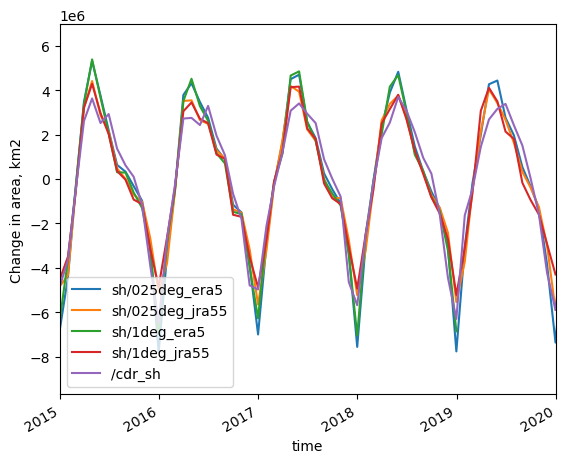

In [70]:
for iGroup in si_rate_dt.groups[1:]:
    ds=si_rate_sh_dt[iGroup].ds.aice*si_rate_sh_dt[iGroup].ds.area_t/1e6
    ds.cf.sum(['X','Y']).plot(label='sh'+iGroup)


for iGroup in ['/cdr_sh']:
    ds=cdr_rate_dt[iGroup].ds
    (ds.cdr_seaice_conc*ds.area).cf.sum(['X','Y']).plot(label=iGroup)

plt.ylabel('Change in area, km2')
plt.xlim(np.datetime64('2015'),np.datetime64('2020'))
plt.legend()

# New Heading

In [98]:
si_rate_sh_dt[iGroup].ds

<xarray.DatasetView>
Dimensions:   (time: 523, yt_ocean: 1080, xt_ocean: 1440)
Coordinates:
    area_t    (yt_ocean, xt_ocean) float32 ...
    geolat_t  (yt_ocean, xt_ocean) float32 ...
    geolon_t  (yt_ocean, xt_ocean) float32 ...
  * time      (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2023-07-31
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
Data variables:
    aice      (time, yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
Attributes: (12/18)
    NCO:                                      netCDF Operators version 5.0.5 ...
    comment3:                                 seconds elapsed into model date...
    contents:                                 Diagnostic and Prognostic Varia...
    conventions:                              CF-1.0
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_attrs:file_id:                 iceh_XXXX_XX_daily
    ...                                       ...
    intake_esm_dataset_key:                   iceh_XXXX_XX_daily.1day
    intake_esm_vars:                          ['aice']
    io_flavor:                                io_pio
    source:                                   Los Alamos Sea Ice Model (CICE)...
    time_period_freq:                         day_1
    title:                                    sea ice model output for CICE

In [138]:
def plot_si_conc(data, kwargs={}):
    """ A function for plotting tri-polar data"""
    ax = plt.gca()

    # Map the plot boundaries to a circle
    # theta = np.linspace(0, 2*np.pi, 100)
    # center, radius = [0.5, 0.5], 0.5
    # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    # circle = mpath.Path(verts * radius + center)
    # ax.set_boundary(circle, transform=ax.transAxes)

    # Add land features and gridlines
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
    #                facecolor = 'gainsboro'), zorder = 2)

    # data.plot.contourf(
    plt.contourf(
        data.geolon_t,
        data.geolat_t,
        data,
        transform=ccrs.PlateCarree(),
        # x = 'geolon_t', 
        # y = 'geolat_t', 
        # levels = np.arange(0.15,1.05,.05),
        # cmap = cmo.balance,
        # cbar_kwargs = {
            # 'label':'Sea Ice Concentration'
        # },
        **kwargs
    )

    # gl = ax.gridlines(
    #     draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--',
    #     ylocs=np.arange(-80,81,10)
    # )

    # ax.coastlines()

In [139]:
def plot_sh_si_conc(to_plot, kwargs={}):
    ax = plt.subplot(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))

    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    
    plot_si_conc(
        to_plot, kwargs
    )

In [73]:
def plot_nh_si_conc(to_plot, kwargs={}):
    ax = plt.subplot(projection=ccrs.NorthPolarStereo(central_longitude=-45))
    
    ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())

    plot_si_conc(
        to_plot, kwargs
    )

In [134]:
x=cdr_rate_dt['cdr_sh'].ds.cdr_seaice_conc.time.sel(time='2017').values[0]

Monthly change in tendency for 2017

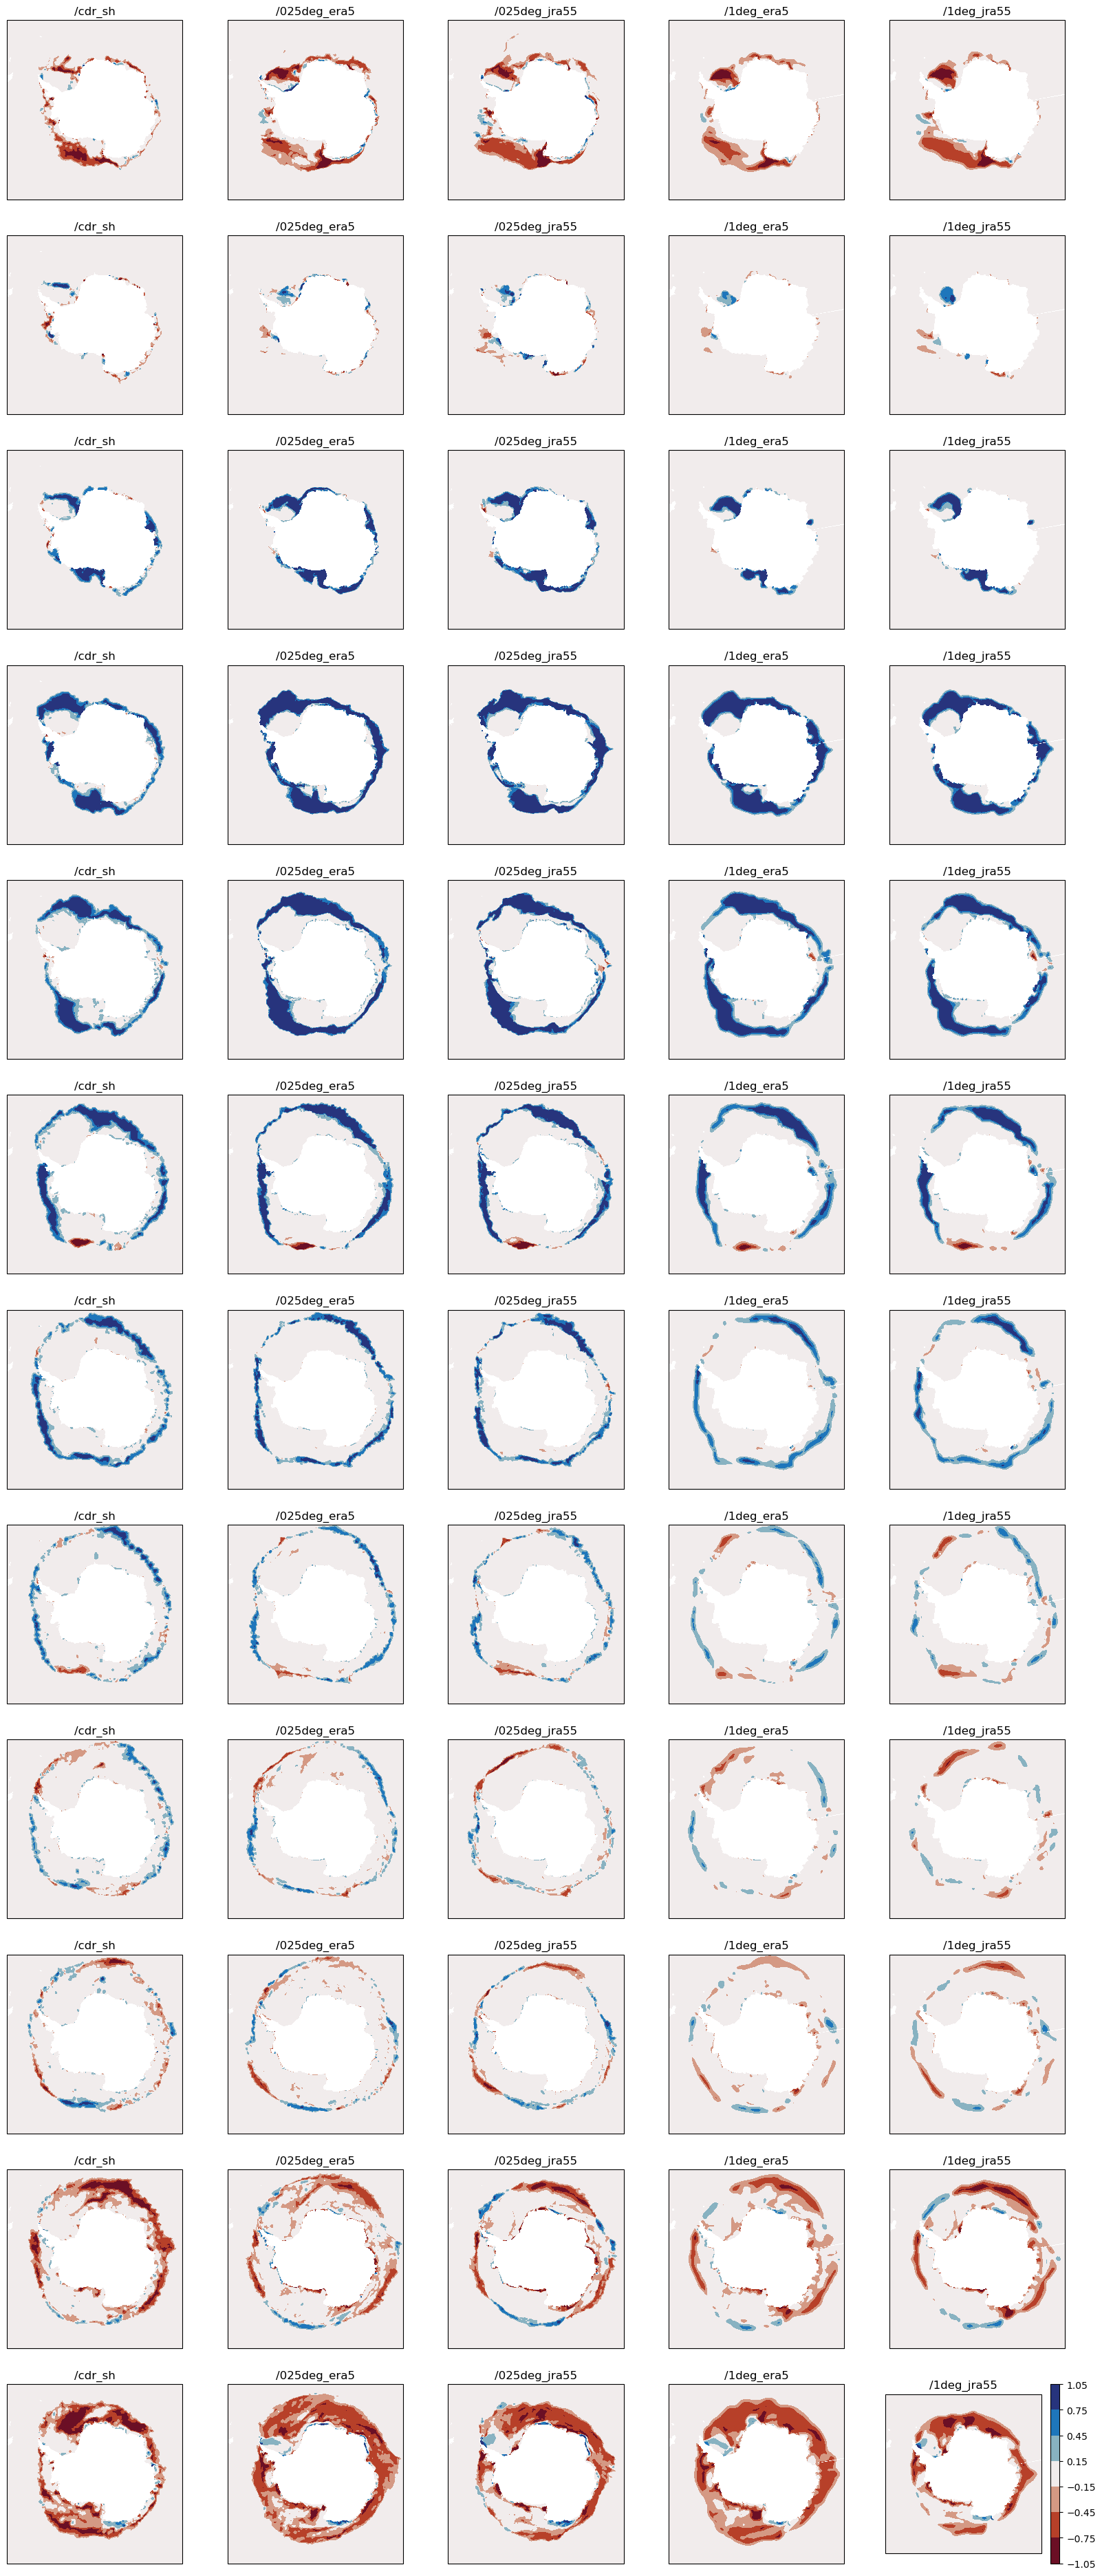

In [144]:
times=cdr_rate_dt['cdr_sh'].ds.cdr_seaice_conc.time.sel(time='2017')

plt.figure(figsize=(20,48))
j=0

for iTime in times:

    i=1
    
    for iGroup in ['/cdr_sh']:
        ds=cdr_rate_dt[iGroup].ds.cdr_seaice_conc.sel(time=iTime)
           
        ax = plt.subplot(12,5,i+j*5,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))

        ax.set_ylabel(str(iTime.values)[0:7])
        
        ax.set_extent([-180, 180, -90, -55], crs=ccrs.PlateCarree())
    
        plt.contourf(
            ds.x, ds.y, ds,
            **{
                'levels':np.arange(-1.05,1.06,.3),
                'cmap':cmo.balance_r
           }
        )
        
        plt.title(iGroup)
        
        i+=1

    
    
    for iGroup in si_rate_dt.groups[1:]:
        ds=si_rate_sh_dt[iGroup].ds.aice.sel(time=iTime)
        
        ax = plt.subplot(12,5,i+j*5,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))
    
        ax.set_extent([-180, 180, -90, -55], crs=ccrs.PlateCarree())
        
        plot_si_conc(
            ds, 
            {
                'levels':np.arange(-1.05,1.06,.3),
                'cmap':cmo.balance_r
            }
        )
    
        plt.title(iGroup)
        
        i+=1

    j+=1

plt.colorbar(fraction=0.1)

Mean monthly change in tendency

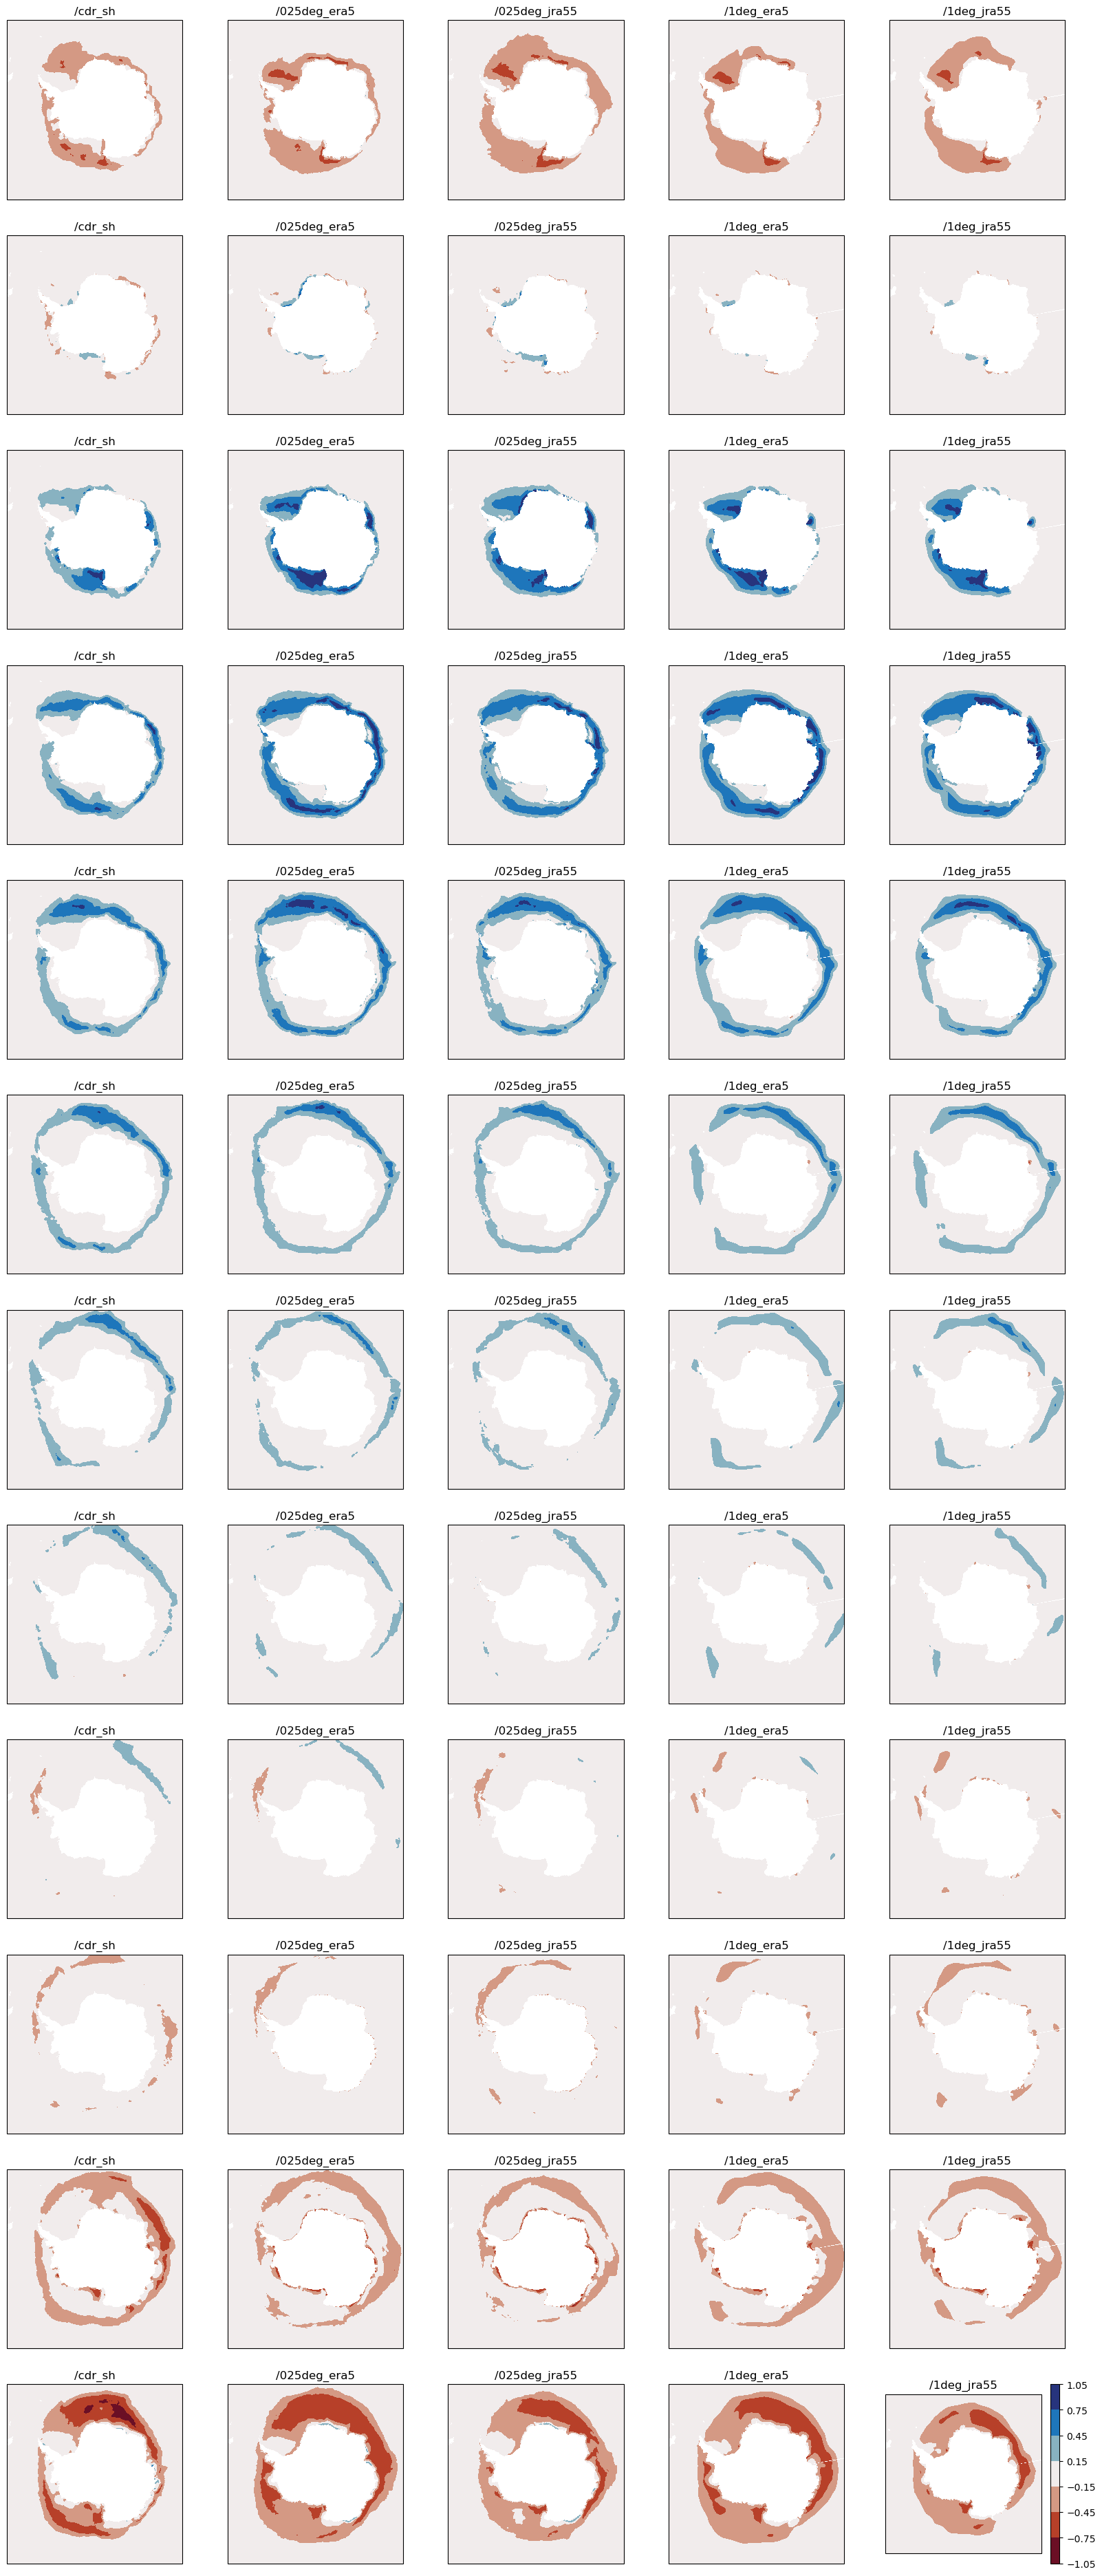

In [146]:
times=np.arange(1,13)

plt.figure(figsize=(20,48))
j=0

for iTime in times:

    i=1
    
    for iGroup in ['/cdr_sh']:
        ds=cdr_rate_dt[iGroup].ds.cdr_seaice_conc
        
        ds=ds.sel(time=ds.time.dt.month.isin(iTime)).mean('time')
           
        ax = plt.subplot(12,5,i+j*5,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))

        # ax.set_ylabel(str(iTime.values)[0:7])
        
        ax.set_extent([-180, 180, -90, -55], crs=ccrs.PlateCarree())
    
        plt.contourf(
            ds.x, ds.y, ds,
            **{
                'levels':np.arange(-1.05,1.06,.3),
                'cmap':cmo.balance_r
           }
        )
        
        plt.title(iGroup)
        
        i+=1

    
    
    for iGroup in si_rate_dt.groups[1:]:
        ds=si_rate_sh_dt[iGroup].ds.aice

        ds=ds.sel(time=ds.time.dt.month.isin(iTime)).mean('time')
        
        ax = plt.subplot(12,5,i+j*5,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))
    
        ax.set_extent([-180, 180, -90, -55], crs=ccrs.PlateCarree())
        
        plot_si_conc(
            ds, 
            {
                'levels':np.arange(-1.05,1.06,.3),
                'cmap':cmo.balance_r
            }
        )
    
        plt.title(iGroup)
        
        i+=1

    j+=1

plt.colorbar(fraction=0.1)